# Imports

In [ ]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append("scripts")
from gene_ROC_AUC import analyze_gene_ROC_AUC

# Summary of samples and diagnosis

In [2]:
annotation = pd.read_csv("../data/annotations_whole_blood.csv", index_col=0)
expressions = pd.read_csv(
    "../data/expression_whole_blood_all_genes.csv", index_col="Gene"
)

In [3]:
diagnosis_stats = annotation.groupby("Diagnosis")["Dataset"].nunique().reset_index()
diagnosis_stats.columns = ["Diagnosis", "N_datasets"]

dataset_lists = annotation.groupby("Diagnosis")["Dataset"].unique().reset_index()
dataset_lists.columns = ["Diagnosis", "Dataset_list"]

sample_counts = annotation["Diagnosis"].value_counts().reset_index()
sample_counts.columns = ["Diagnosis", "N_samples"]

summary = diagnosis_stats.merge(dataset_lists, on="Diagnosis").merge(
    sample_counts, on="Diagnosis"
)

total_row = pd.DataFrame(
    {
        "Diagnosis": ["Total"],
        "N_datasets": [summary["N_datasets"].sum()],
        "Dataset_list": [None],
        "N_samples": [summary["N_samples"].sum()],
    }
)

summary = pd.concat([summary, total_row], ignore_index=True)
summary.to_csv("../data/summary.csv")

In [4]:
summary

,Diagnosis,N_datasets,Dataset_list,N_samples
0,Ankylosing_spondylitis,1,[GSE117769],8
1,Arthropathic_psoriasis,1,[GSE117769],10
2,Crohn_disease,1,[GSE112057],60
3,Healthy,12,"[GSE117769, GSE183701, GSE176260, GSE112087, G...",292
4,Juvenile_idiopathic_arthritis,1,[GSE112057],115
5,Psoriasis,1,[GSE147339],10
6,Relapsing-remitting_multiple_sclerosis,1,[GSE159225],20
7,Rheumatoid_arthritis,3,"[GSE120178, GSE90081, GSE117769]",190
8,Secondary_progressive_multiple_sclerosis,1,[GSE159225],10
9,Systemic_inflammatory_response_syndrome,1,[GSE176260],17


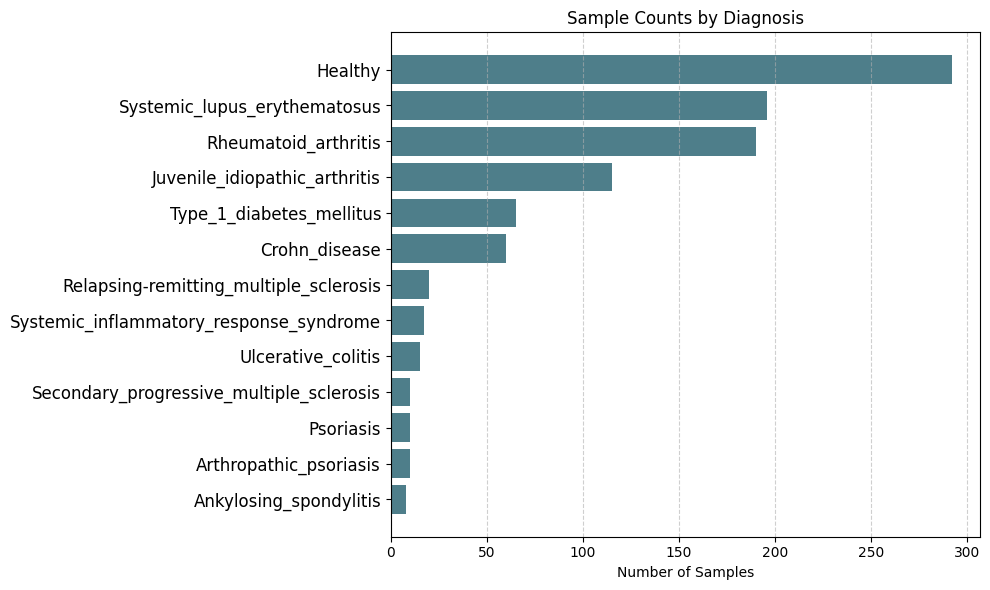

In [5]:
summary = pd.read_csv("../data/summary.csv")

summary_no_total = summary[summary["Diagnosis"] != "Total"]
summary_sorted = summary_no_total.sort_values("N_samples", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(summary_sorted["Diagnosis"], summary_sorted["N_samples"], color="#4E7E8A")
plt.xlabel("Number of Samples")
plt.yticks(fontsize=12)
plt.title("Sample Counts by Diagnosis")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("../images/sample_counts_by_diagnosis.png", dpi=300, bbox_inches="tight")
plt.show()

# Analysis of gene's ROC AUC (Healthy vs Disease)

In [6]:
expr = expressions
ann = annotation
common_samples = list(set(expr.columns) & set(ann.index))

expr_filtered = expr[common_samples]
datasets = ann.loc[common_samples, ["Dataset", "Diagnosis"]]

In [7]:
results_df = analyze_gene_ROC_AUC(
    expr=expr, ann=ann, gene_list_path="../data/final_dif_gene_list.txt"
)
results_df.head()

,Gene,Dataset,Diagnosis,ROC_AUC,p-value,Direction_in_Disease
3038,SAT1,GSE112087,Systemic_lupus_erythematosus,0.895996,7.685730e-14,Up
1355,EIF2AK2,GSE112087,Systemic_lupus_erythematosus,0.883760,4.339635e-13,Up
2545,ABCA1,GSE112087,Systemic_lupus_erythematosus,0.872914,1.926371e-12,Up
1576,NCR3,GSE112087,Systemic_lupus_erythematosus,0.127642,2.077073e-12,Down
3021,IFIT3,GSE112087,Systemic_lupus_erythematosus,0.864016,6.345793e-12,Up


In [8]:
results_df_roc = results_df.query("ROC_AUC >= 0.55")
df_up = results_df_roc.query("Direction_in_Disease == 'Up'")

In [9]:
filtered_up = df_up.query("ROC_AUC > 0.55").drop_duplicates()
filtered_up["Direction_in_Disease"] = (
    filtered_up["Direction_in_Disease"].str.strip().str.capitalize()
)

dataset_counts = (
    filtered_up.groupby("Gene")["Dataset"].nunique().rename("Dataset_Count")
)

up_counts = (
    filtered_up.groupby(["Gene", "Direction_in_Disease"]).size().unstack(fill_value=0)
)

up_counts = up_counts.merge(dataset_counts, left_index=True, right_index=True)
up_counts["Up_percentage"] = (up_counts["Dataset_Count"] / up_counts["Up"]) * 100

stable_up = up_counts[up_counts["Up_percentage"] > 50]
stable_gene_list = stable_up.index.tolist()
stable_results = filtered_up[filtered_up["Gene"].isin(stable_gene_list)]
stable_up

,Up,Dataset_Count,Up_percentage
Gene,,,
ABCA1,9,9,100.000000
ABCA13,7,7,100.000000
AC007325.1,9,8,88.888889
ACSL1,10,8,80.000000
ADAMTS2,10,9,90.000000
...,...,...,...
TTC26,10,8,80.000000
VNN1,8,8,100.000000
VNN2,10,7,70.000000


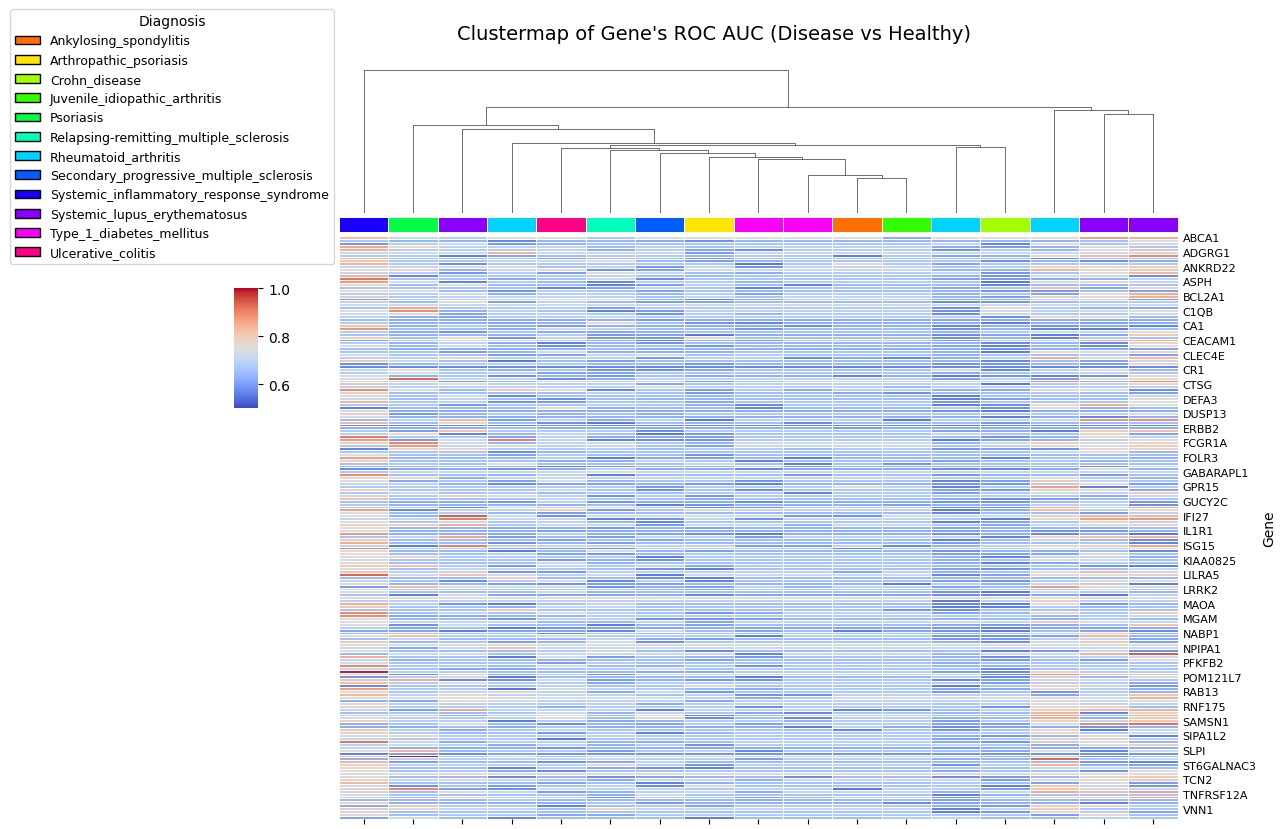

In [10]:
filtered_results = stable_results.drop_duplicates()

roc_matrix = filtered_results.pivot(
    index="Gene", columns=["Dataset", "Diagnosis"], values="ROC_AUC"
)
roc_matrix.columns = [
    f"{dataset} - {diagnosis}" for dataset, diagnosis in roc_matrix.columns
]
roc_matrix = roc_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

unique_diagnoses = sorted(filtered_results["Diagnosis"].unique())
palette = sns.color_palette("hsv", len(unique_diagnoses))
diagnosis_colors = dict(zip(unique_diagnoses, palette))
col_colors = [diagnosis_colors[col.split(" - ")[1]] for col in roc_matrix.columns]
from matplotlib.patches import Patch

legend_patches = [
    Patch(facecolor=color, edgecolor='black', label=diagnosis)
    for diagnosis, color in diagnosis_colors.items()
]

g = sns.clustermap(
    roc_matrix,
    cmap="coolwarm",
    col_cluster=True,
    row_cluster=False,
    linewidths=0.5,
    figsize=(12, 12),
    col_colors=col_colors,
    vmin=0.5,
    vmax=1,
    cbar_pos=(0.1, 0.7, 0.02, 0.1),
    colors_ratio=(0.03, 0.02),
)

g.ax_cbar.set_label("ROC AUC Score")
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=8)
g.ax_heatmap.yaxis.set_tick_params(length=0)
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.legend(
    handles=legend_patches,
    title="Diagnosis",
    fontsize=9,
    title_fontsize=10,
    bbox_to_anchor=(-0.4, 1.4),
    loc="upper left",
)
g.fig.suptitle("Clustermap of Gene's ROC AUC (Disease vs Healthy)", fontsize=14, y=1.02)
plt.savefig("../images/ROC_AUC.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
print("Stable Up Genes:", stable_gene_list)

Stable Up Genes: ['ABCA1', 'ABCA13', 'AC007325.1', 'ACSL1', 'ADAMTS2', 'ADGRG1', 'AIM2', 'ALAS2', 'ALOX5AP', 'ANK1', 'ANKRD22', 'ANXA3', 'AP5B1', 'AQP9', 'ARG1', 'ASPH', 'AZU1', 'B2M', 'B4GALT5', 'BATF2', 'BCL2A1', 'BMX', 'BPI', 'BZRAP1', 'C1QA', 'C1QB', 'C1QC', 'C3AR1', 'C4BPA', 'C5AR1', 'CA1', 'CA4', 'CACNA1E', 'CAMP', 'CD177', 'CEACAM1', 'CEACAM6', 'CEACAM8', 'CH507-396I9.6', 'CLEC4D', 'CLEC4E', 'CMPK2', 'CNGB1', 'COL17A1', 'COL5A2', 'CR1', 'CREB5', 'CRISP3', 'CSRNP1', 'CSTA', 'CTSG', 'CXCL8', 'CYSTM1', 'DAAM2', 'DEFA1', 'DEFA3', 'DEFA4', 'DHRS9', 'DSC2', 'DUSP1', 'DUSP13', 'ECHDC3', 'EIF2AK2', 'ELANE', 'ELOVL7', 'ERBB2', 'ETV7', 'F5', 'FCAR', 'FCER1G', 'FCGR1A', 'FCGR1B', 'FFAR3', 'FGD4', 'FKBP5', 'FOLR3', 'FPR2', 'FST', 'G0S2', 'GAB2', 'GABARAPL1', 'GADD45A', 'GALNT14', 'GCA', 'GK', 'GPR15', 'GPR27', 'GPR42', 'GPR84', 'GRB10', 'GUCY2C', 'HECW2', 'HMGB2', 'HP', 'HTRA3', 'IFI27', 'IFIT3', 'IFITM2', 'IFITM3', 'IL18R1', 'IL1R1', 'IL1R2', 'IL1RN', 'INHBB', 'IRAK3', 'ISG15', 'ITGA7', 'K

In [12]:
with open("../data/stable_genes.txt", "w") as f:
    for gene in stable_gene_list:
        f.write(gene + "\n")